# Diffusion Model met Fashion MNIST in PyTorch

Het doel van dit notebook is om een diffusion model te implementeren dat leert om ruis van afbeeldingen te verwijderen en nieuwe afbeeldingen van mode-items te genereren die vergelijkbaar zijn met de Fashion MNIST dataset.

## Importeren van packages en dataset

In onderstaande code worden de volgende stappen uitgevoerd:
* Laad de Fashion MNIST dataset en normaliseer de afbeeldingen naar het bereik [-1, 1]
* Maak een DataLoader om batches van trainingsgegevens te genereren
* Voeg functies toe om eenvoudiger te kunnen werken met ruis

Data geladen en DataLoader klaar.
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 8, 5, 9, 9, 0, 5, 3])


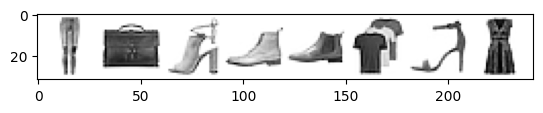

In [1]:
# Importeren van benodigde bibliotheken
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# Controleer of er een GPU beschikbaar is, zo niet gebruik de CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data-transformatie: normaliseer de afbeeldingen zodat de pixelwaarden tussen -1 en 1 liggen
transform = transforms.Compose([
    transforms.ToTensor(),  # Converteert beeld naar tensor
])

# FashionMNIST dataset downloaden en laden
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader voor batches van de trainingsdata
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

print("Data geladen en DataLoader klaar.")

x, y = next(iter(train_loader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

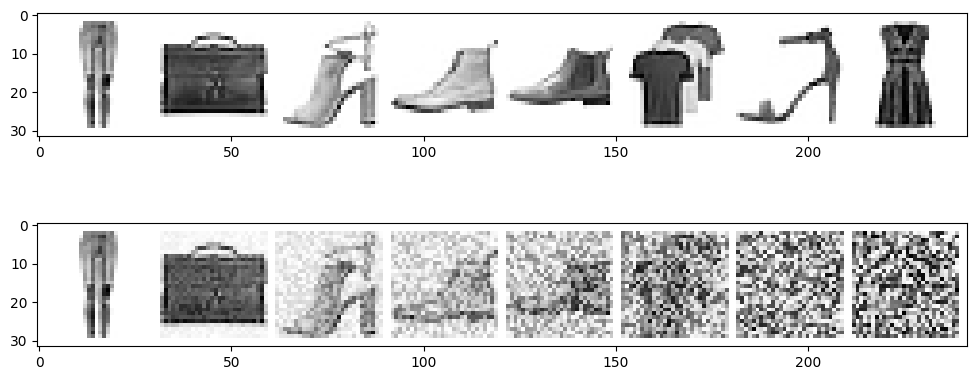

In [3]:
def add_noise(img, amount):
    noise = torch.rand_like(img) # maak random-waarden met dezelfde shape als de parameter (hier img), waarden tussen 0 en 1
    amount = amount.view(-1,1,1,1) # maak de shape van amount (batch_size, 1, 1, 1)
    return img * (1-amount) + noise * amount

fig, axs = plt.subplots(2, 1, figsize=(12,5))
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

amount = torch.linspace(0, 1, x.shape[0]) # x_shape[0] waarden verdeeld over de range 0 en 1 : gelijkaardig aan -> 0:1:0.1
noised_x = add_noise(x, amount)

axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')


## Bouwen van een model

In deze notebook gaan we werken met een eenvoudig U-Net model dat de taak van ruisvoorspelling uitvoert. Het model bestaat uit encoder-, midden- en decoderlagen. Het model voorspelt de ruis die is toegevoegd aan een afbeelding en probeert deze te verwijderen.
Ook andere modellen kunnen hiervoor gebruikt worden.

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # omgekeerde van conv2d + maxpool2d
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), # 1 want we maken grijswaarden beelden
            nn.Tanh() # waarden tussen -1 en 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)

        return x

model = UNet()
print(model)

x = torch.rand(8, 1, 28, 28)
model(x).shape

UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
)


torch.Size([8, 1, 28, 28])

## Trainen van het model

Om het model te trainen wordt de verliesfunctie MSE-loss en de Adam-optimizer gebruikt. 
Daarnaast berekenen we de betas voor het diffusieproces met behulp van een lineaire verdeling over 1000 timesteps.

Ten slotte wordt het diffusiemodel getraind. Voor elke batch van trainingsafbeeldingen wordt een willekeurige tijdstap gekozen om ruis toe te voegen aan de afbeelding. Het model leert vervolgens de toegevoegde ruis te voorspellen en te verwijderen. Voor elke epoch wordt het verlies uitgeprint.

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss=0
    for n, (images, _) in enumerate(train_loader):
        # add noise
        noise_amount = torch.rand(images.shape[0]) # batch_size random waarden
        noise_images = add_noise(images, noise_amount)

        # forward pass
        optimizer.zero_grad()
        output = model(noise_images)
        loss = criterion(output, images)

        # backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

## Visualisatie

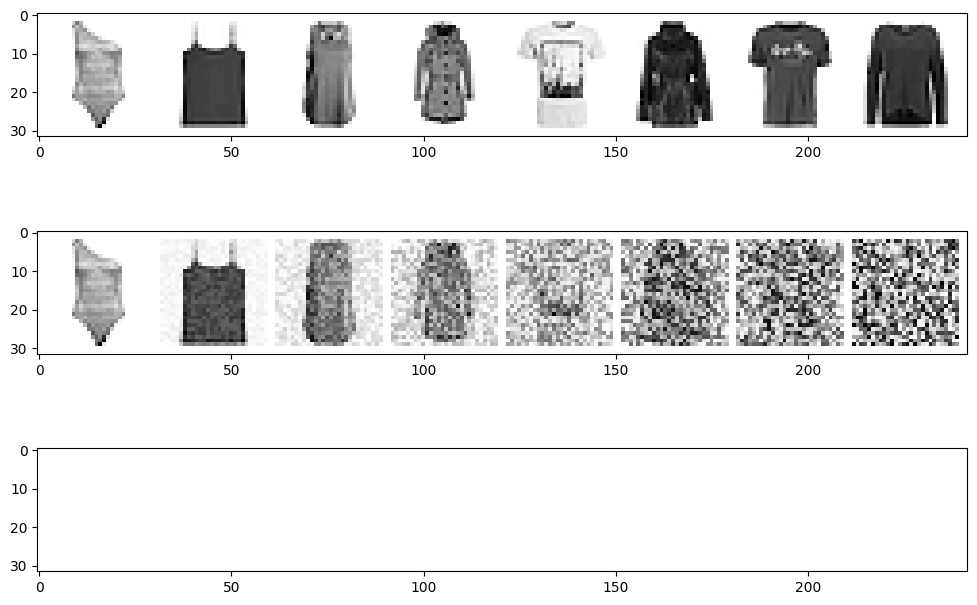

In [12]:
x, y = next(iter(train_loader))

fig, axs = plt.subplots(3, 1, figsize=(12,8))
# toon originele beelden
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

amount = torch.linspace(0, 1, x.shape[0]) # x_shape[0] waarden verdeeld over de range 0 en 1 : gelijkaardig aan -> 0:1:0.1
noised_x = add_noise(x, amount)

# toon ruisbeelden
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

# toon gegenereerde beelden
with torch.no_grad():
    output = model(noised_x)

axs[2].imshow(torchvision.utils.make_grid(output)[0], cmap='Greys')

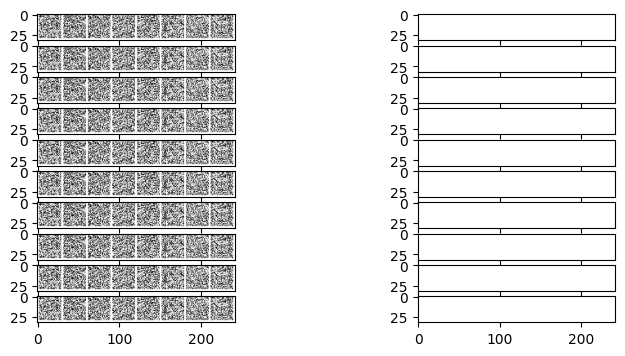

In [13]:
n_steps = 10
x = torch.rand(8,1, 28, 28) # in de realiteit begin je van ruis

step_history = [x]
pred_history = []

for i in range(n_steps):
    with torch.no_grad():
        output = model(x)
    pred_history.append(output)

    # omdat we met een vereenvoudigde versie werken, gebruiken we hier een mix_factor om het stapsgewijs proces na te bootsen
    mix_factor = 1/(n_steps-i)
    x = x * (1 - mix_factor) + output * mix_factor

    step_history.append(x)

fig,axs = plt.subplots(n_steps, 2, figsize=(9,4), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_history[i])[0], cmap='Greys')

### Opmerkingen:

De hierboven gevolgde aanpak is een vereenvoudigde voorstelling van de state-of-the-art diffusion model die wel goed de te volgen concepten uitlegt.
Een meer gedetailleerde uitleg van diffusion models vind je [DDPM paper](https://arxiv.org/abs/2006.11239)
In deze paper breiden ze het voorbeeld in deze notebook uit door:
* Een geavanceerder UNet-model te gebruiken
* Een complexere manier om ruis toe te voegen
* Niet rechtstreeks het begin image te voorspellen maar de ruis in een image te voorspellen
* Gebruik een timestep in plaats van een amount-waarde